<center>
<img src="https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/img/this_is_data_anal.png" width="200" height="200"><br>
</center>

## 4.2 강남역 맛집 리뷰로 알아보는 감성 분류

분류 모델의 가장 대표적인 활용 방법 중 하나는 바로 감성 분류이다. 감성 분류란 문서를 긍정의견 또는 부정의견으로 나누어 분류하는 것이다. 이번엔 강남역 맛집 리뷰 데이터를 활용하여 감성 분류를 수행해보자.

### step.1 크롤링: 네이버 플레이스 리뷰 크롤링

첫 번째 단계에서는 크롤링을 이용하여 감성 분류에 필요한 데이터를 직접 수집하자. 이번에 크롤링할 데이터는 네이버 플레이스의 음식점 랭킹 정보이다. 네이버 플레이스 API는 별도의 라이브러리 설치나 개발자 등록 없이 source_url에 검색 규칙을 추가하는 것만으로도 크롤링을 적용할 수 있다. 아래의 코드와 같이 start, display, query, sortingOrder 파라미터로 검색 규칙을 추가하자.

- start, display : 검색 결과를 얼마만큼 보여줄지에 관련된 파라미터
- query : 검색하고 싶은 장소나 음식점에 대한 검색어
- sortingOrder : 어떤 방식으로 검색 결과를 정렬할지에 대한 파라미터

검색 규칙을 추가한 url_concat에 request.get 함수를 적용하면 json 형태의 검색 결과 데이터를 얻을 수 있다. 그리고 이를 jason.loads 함수로 변환하면 파이썬의 dictionary와 동일한 형태로 사용할 수 있다.

In [2]:
# -*- coding: utf-8-*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

### step.2 텍스트 전처리: 분류 모델 피처로 변환하기

이번 단계에는 텍스트 데이터를 감성 분류의 피처로 사용할 수 있도록 하는 텍스트 전처리 과정이다.

- 한글 텍스트로 전처리하기

In [3]:
import re

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [4]:
df = pd.read_csv("/home/jaeyoon89/python-data-analysis/chapter4/review_data.csv")
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']
df.head()

,score,y,ko_text
0,5,1,친절하시고 깔끔하고 좋았습니다
1,5,1,조용하고 고기도 굿
2,4,1,갈비탕과 냉면 육회비빔밥이 맛있습니다
3,4,1,대체적으로 만족하나와인의 구성이 살짝 아쉬움
4,5,1,고기도 맛있고 서비스는 더 최고입니다


형태소를 추출하는 전처리 과정도 진행하자. 아래 코드에서 형태소/품사의 형태로 데이터를 추출하는 get_pos()라는 함수를 정의했고 이 함수에 대한 테스트 코드 실행 결과는 아래와 같다.

- 형태소 단위의 추출 함수 정의하기

In [5]:
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'][0])
print(result)

['친절하시고/Adjective', '깔끔하고/Adjective', '좋았습니다/Adjective']


이제 텍스트 데이터의 마지막 전처리 과정이다. 이번 단계의 핵심은 텍스트 데이터를 분류 모델에 학습이 가능한 데이터셋으로 만드는 것이다.

텍스트 데이터를 연산 가능한 피처로 만드는 방법은 다음과 같다.

- 1. raw 데이터셋 : 데이터 프레임의 텍스트 데이터에 해당한다.
- 2. 말뭉치 : raw 데이터셋으로부터 말뭉치를 생성한다. 이 말뭉치는 형태소의 서로 다른 고유한 셋을 가지고 있다.
- 3. 학습 데이터셋 : 서로 다른 6개의 형태소는 각 텍스트 데이터의 벡터 길이가 된다. 만약 텍스트에 해당 단어가 존재하면 벡터의 값을 1로, 존재하지 않으면 벡터의 값을 0으로 할당한다.

파이썬에선느 sklearn.feature_extraction.text 라이브러리의 CountVectorizer라는 클래스를 통해 이 작업을 쉽게 수행할 수 있다. CountVectorizer 클래스의 tokenizer 파라미터는 텍스트 데이터의 전처리 방식을 입력하는 것이고, 이 객체에 df['ko_text'].tolist()을 입력값으로 fit_transform을 실행하면 학습 데이터셋을 생성할 수 있다.

- 분류 모델의 학습 데이터로 변환하기 : corpus index 생성

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())
print(X.shape)                                  

(545, 3030)


학습 데이터셋과 말뭉치가 올바르게 생성되었는지를 확인해보자.

- 분류 모델의 학습 데이터로 변환하기

In [9]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'친절하시고/Adjective': 2647, '깔끔하고/Adjective': 428, '좋았습니다/Adjective': 2403, '조용하고/Adjective': 2356, '고..


In [10]:
print(df['ko_text'][0])
print(X[0])

친절하시고 깔끔하고 좋았습니다
  (0, 2647)	1
  (0, 428)	1
  (0, 2403)	1


하지만 텍스트 데이터에 중복되는 형태소가 존재한다면 어떻게 될까? 만약 '너무 좋았습니다', '너무 너무 너무 좋았습니다' 라는 두 텍스트 데이터가 있다면 중복되는 형태소 '너무' 가 존재하기 때문에 이 둘은 같은 데이터로 변환된다. 이 문제를 해결하기 위해 텍스트를 피처로 만드는 다른 방법인 TF-IDF를 적용해 보자.

- 분류 모델의 학습 데이터로 변환하기 : TF-IDF로 변환

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환한다.
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)
print(X.shape)
print(X[0])

(545, 3030)
  (0, 2647)	0.5548708693511647
  (0, 2403)	0.48955631270748484
  (0, 428)	0.6726462183300624


'친절하시고 깔끔하고 좋았습니다' 라는 텍스트 데이터가 TF-IDF 피처로 표현된 것을 볼 수 있다.

### Step.3 분류: 긍정/부정 리뷰 분류하기

이제 감성 분류를 위한 데이터셋이 모두 준비 되었다. sklearn.model_selection에서 제공하는 train_test_split() 함수를 사용하여 훈련 데이터셋과 테스트 데이터셋으로 데이터를 분리하자.

- 분류 모델링 : 데이터셋 분리

In [13]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(381, 3030)
(164, 3030)


- 분류 모델링 : 로지스틱 회귀 모델

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [18]:
# 로지스틱 회귀 모델을 학습한다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

In [19]:
# 로지스틱 회귀 모델의 성능을 평가한다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.85
Precision : 0.854
Recall : 1.000
F1 : 0.921


실행 결과 대부분의 평가 수치가 높은 것을 볼 수 있다. 이렇게 분류기의 성능이 비정상적으로 높은 경우 모델의 평가 방법이나 과정을 의심해볼 필요가 있다. 이러한 의심을 직접 해소하기 위해 Confusion Matrix를 출력해 보자.

In [20]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력한다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[  0  24]
 [  0 140]]


하지만 출력 결과가 이상하다. 이 분류 모델은 모든 데이터를 '1'로 예측하고 있다. 모델이 하나의 결과만을 예측하도록 잘못된 학습을 한 것이다. 이러한 현상을 클래스의 불균형 문제라고 한다. 이는 데이터의 Positive sample(1)과 Negative sample(0)의 비율이 크게 차이가 나는 경우에 발생한다. 그래서 적절한 샘플링 방법을 통해 클래스의 불균형 문제를 해경해야 한다.

- 클래스 불균형 문제 해결하기

In [22]:
# y가 0과 1을 각각 얼마나 가지고 있는지 출력한다.
df['y'].value_counts()

1    492
0     53
Name: y, dtype: int64

이제 두 클래스간의 비율을 동일하게 맞춰주는 방법을 생각해볼 수 있다. 다음 코드는 클래스를 1:1 비율로 샘플링하기 위해 y가 1인 50개의 샘플, y가 0인 50개의 샘플을 임의로 추출한다. 그리고 이 데이터를 다시 훈련 데이터셋(70개)과 테스트 데이터셋 (30개)로 분리하는 방법을 사용한다.

- 클래스 불균형 문제 해결하기 : 1:1 비율의 랜덤 샘플링

In [24]:
# 1:1 비율로 랜덤 샘플링을 수행한다.
positive_random_idx = df[df['y']==1].sample(50, random_state=30).index.tolist()
negative_random_idx = df[df['y']==0].sample(50, random_state=30).index.tolist()

In [25]:
# 랜덤 데이터로 데이터셋을 나눈다.
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(sample_X,y,test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(70, 3030)
(30, 3030)


균형을 맞춰 샘플링한 데이터로 학습과 평가를 진행해보자. 이전보다 모델의 정확도는 떨어졌지만, 상식적인 수준에서 납득할 수 있을 정도의 성능으로 변하였다.

- 로지스틱 회귀 모델 다시 학습하기

In [26]:
# 로지스틱 회귀 모델을 학습한다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

In [27]:
# 로지스틱 회귀 모델의 성능을 평가한다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.67
Precision : 1.000
Recall : 0.412
F1 : 0.583


In [28]:
# Confusion Matrix를 출력한다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[13  0]
 [10  7]]


그리고 Confusion Matrix를 살펴본 결과, 새롭게 학습한 분류 모델은 0과 1 두 클래스를 비슷한 비율로 예측하고 있다는 것을 알 수 있다.

### Step.4  분석: 중요 키워드 분석하기

지금까지 학습한 감성 분류 모델에서는 어떤 형태소가 높은 영향력을 가지고 있을까? 이를 알아보기 위해 로지스틱 회귀 모델의 피처 영향력을 추출해보자.

3030개 형태소 각각의 설명 변수는 다음의 그래프와 같다. 이 중 양수인 피처들은 리뷰에서 긍정적이라고 판단되는 형태소이며, 음수인 피처들은 리뷰에서 부정적으로 판단되는 형태소라고 생각할 수 있다.

- 회귀 모델의 피처 영향력 추출하기

<BarContainer object of 3030 artists>

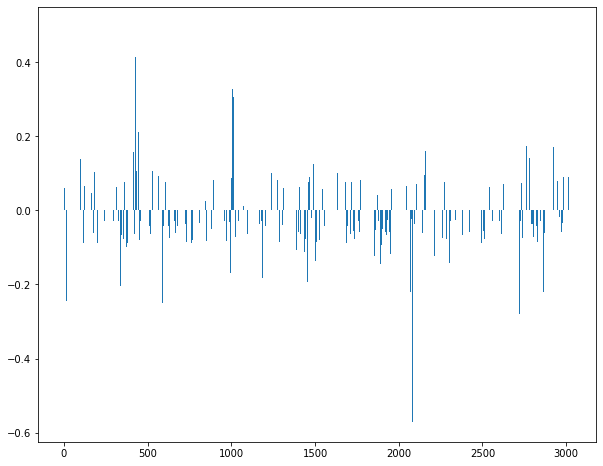

In [31]:
# 학습한 회귀 모델의 계수를 출력한다.
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [32]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(0.4961545122468287, 2247), (0.41328589020115997, 428), (0.3827536188931886, 138), (0.34690710642796724, 2529), (0.32966315259655804, 999)]
[(-0.3765256755576704, 980), (-0.3981931936531049, 399), (-0.48992478626966, 2312), (-0.5435995891558263, 2069), (-0.571550086128544, 2082)]


- 중요 변수의 형태소

In [33]:
# 회귀 모델의 계수를 높은 순으로 정렬한다.
coef_pos_index = sorted(((value,index) for index, value in enumerate(lr.coef_[0])), reverse=True)

# 회귀 모델의 계수를 index_vectorizer에 맵핑하여 어떤 형태소인지 출력할 수 있게 한다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로 피처에 형태소를 맵핑한 결과를 출력한다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있다.
print(str(invert_index_vectorizer)[:100]+'..')

{2647: '친절하시고/Adjective', 428: '깔끔하고/Adjective', 2403: '좋았습니다/Adjective', 2356: '조용하고/Adjective', 23..


피처 영향력을 기준으로 정렬된 형태소의 상위 20개 출력 결과는 아래와 같다. 이는 맛집 분류에 긍정적인 영향을 미친 상위 20개의 형태소라고 볼 수 있다. 

- 상위 20개 긍정 형태소 출력하기

In [35]:
# 상위 20개 긍정 형태소 출력하기
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

잘/VerbPrefix 0.4961545122468287
깔끔하고/Adjective 0.41328589020115997
갑니다/Verb 0.3827536188931886
짱/Suffix 0.34690710642796724
맛있게/Adjective 0.32966315259655804
맛있는/Adjective 0.32810487621305595
맛있었어요/Adjective 0.3080499178268471
맛있습니다/Adjective 0.30666611681517675
먹었습니다/Verb 0.2689634439221225
좋아요/Adjective 0.2673200764423626
환기/Noun 0.2670045523142115
먹음/Noun 0.26374533078477297
합/Noun 0.2527182309556622
추천/Noun 0.24628138787452025
삼/Modifier 0.24564915451477506
같이/Adverb 0.23431479074232714
사랑/Noun 0.23417885781932188
올/Modifier 0.23376855763184246
진짜/Noun 0.23057898952503933
비싸다여/Adjective 0.23032120503306963


출처 : 이것이 데이터 분석이다 with 파이썬